# Analysis for the Modeling Game

In [1]:
%matplotlib inline
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

import tellurium as te
import gene_network as gn
import modeling_game as mg
import model_fitting as mf
import gene_analyzer as ga
import util

## Analysis Codes

In [2]:
def evaluate(desc_stgs, **kwargs):
    analyzer = ga.GeneAnalyzer()
    for desc_stg in desc_stgs:
        analyzer.do(desc_stg, **kwargs)
        title = "%s: Rsq = %1.2f" % (desc_stg, analyzer.rsq)
        plt.figure()
        analyzer.plot(title=title)
    return analyzer

## Explorations of Gene Structures

In [3]:
analyzers = []

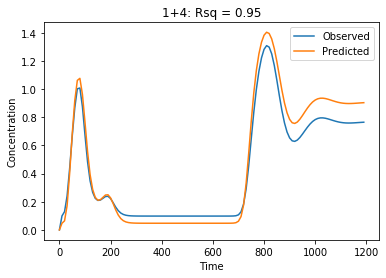

In [4]:
analyzers.append(evaluate(["1+4"], max_iteration=20, start_time=0, end_time=1200))

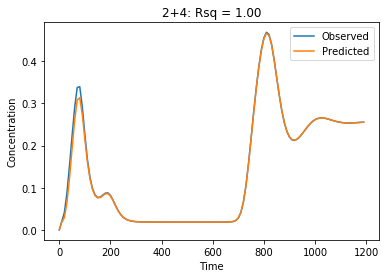

In [5]:
analyzers.append(evaluate(["2+4"], max_iteration=20, start_time=0, end_time=1200))

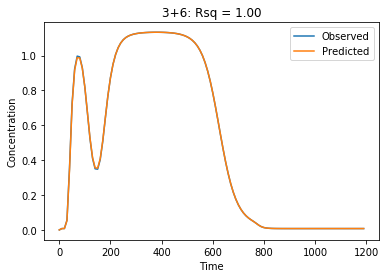

In [6]:
analyzers.append(evaluate(["3+6"], max_iteration=20, start_time=0, end_time=1200))

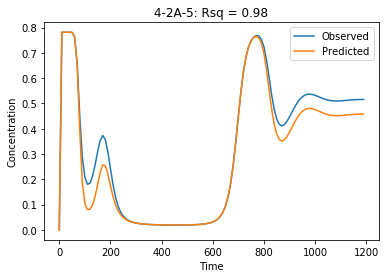

In [7]:
analyzers.append(evaluate(["4-2A-5"], max_iteration=20, start_time=0, end_time=1200))

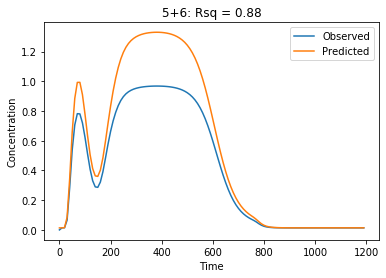

In [8]:
analyzers.append(evaluate(["5+6"], max_iteration=20, start_time=0, end_time=1200))

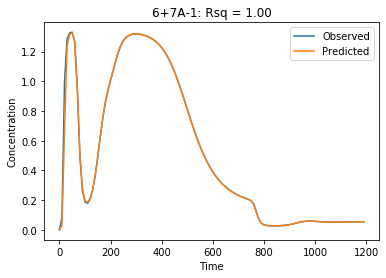

In [9]:
analyzers.append(evaluate(["6+7A-1"], max_iteration=20, start_time=0, end_time=1200))

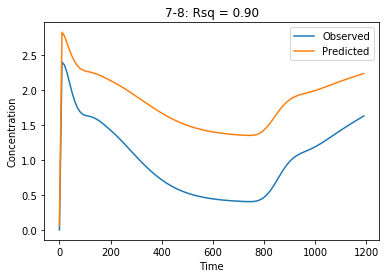

In [10]:
analyzers.append(evaluate(["7-8"], max_iteration=20, start_time=0, end_time=1200))

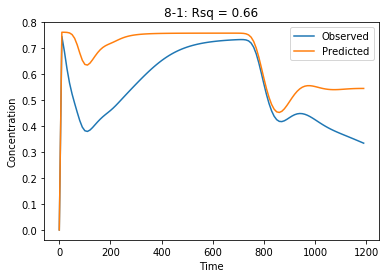

In [11]:
analyzers.append(evaluate(["8-1"], max_iteration=30, start_time=0, end_time=1200))

## Generate the New Simulation Model

In [12]:
len(analyzers[1].network.new_parameters)

0

In [13]:
dfs = []
for analyzer in analyzers:
    dfs.append(analyzer.makeParameterDF())
df_param = pd.concat(dfs)
df_param = df_param.set_index('name')
df_param = df_param.drop(['Vm1'])
df_param = df_param.reset_index()
df_param.to_csv("parameters.csv", index=False)

In [14]:
df_param

,name,value
0,K3_4,0.016201
1,K2_4,0.017792
2,K1_5,0.024552
3,H5,3.375912
4,Vm5,1.297089
5,H7,2.078645
6,K1_7,0.029910
7,Vm7,1.743238


In [15]:
dfs = []
for analyzer in analyzers:
    dfs.append(analyzer.makeParameterDF())
df_param = pd.concat(dfs)
df_param = df_param.set_index('name')
df_param = df_param.drop(['Vm1'])
df_param = df_param.reset_index()
df_param.to_csv("parameters.csv", index=False)

In [16]:
# Eliminate updates to Vm1
augmented_network = ["4-2A-5", "5+6", "7-8"]
network = gn.GeneNetwork()
network.update(augmented_network)
# Add the new parameters
for analyzer in analyzers:
    if len(analyzer.network.parameters) > 0:
        #print(analyzer.parameters)
        network.addInitialization(analyzer.parameters)
network.generate()
with open("full_model.txt", "w") as fd:
    fd.write(network.model)
#print(network.model)

## Full Model Analysis

In [17]:
import run_game

--Return--
> /home/ubuntu/advancing-biomedical-models/ModelingGame/run_game.py(41)evaluate()->None
-> import pdb; pdb.set_trace()
(Pdb) c


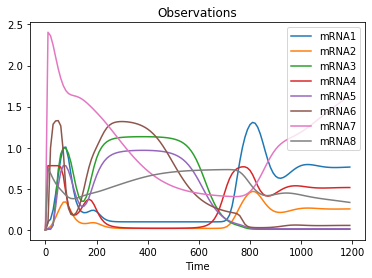

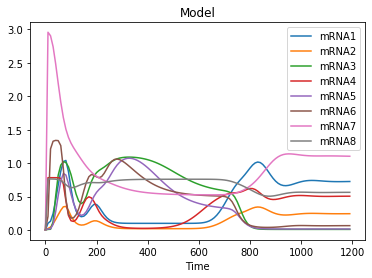

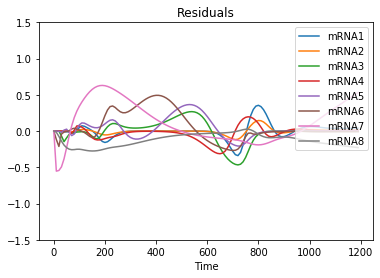

In [18]:
run_game.evaluate()

In [19]:
parameters = mg.makeParameters(df_param['name'], df_param['value'])
parameters

name,value,initial value,min,max,vary
K3_4,0.01620100,0.016200996506415277,0.01000000,0.03000000,True
K2_4,0.01779170,0.017791698422144175,0.01000000,0.03000000,True
K1_5,0.02455170,0.024551697601124887,0.01000000,0.03000000,True
H5,3.37591239,3.3759123946511225,2.00000000,8.00000000,True
Vm5,1.29708936,1.2970893610096152,0.50000000,2.00000000,True
H7,2.07864473,2.0786447260190846,2.00000000,8.00000000,True
K1_7,0.02990961,0.029909606080783503,0.01000000,0.03000000,True
Vm7,1.74323828,1.7432382777840103,0.50000000,2.00000000,True


In [20]:
df_mrna = df_mrna.drop(df_mrna.index[-1])
len(df_mrna)

NameError: name 'df_mrna' is not defined

In [ ]:

df_mrna = pd.read_csv("wild.csv")
df_mrna = df_mrna.set_index('time')
mf.fit(df_mrna, model=FULL_MODEL, parameters=parameters, sim_time=1200, num_points=120)


## Correlation Analysis
The goal here is to gain intuition about possible TF configurations for genes.

1. Construct cross correlatons between mRNA and proteins at different time lags. Plt as heatmap.

In [ ]:
df_mrna = pd.read_csv("wild.csv")
df_mrna = df_mrna.set_index("time")

In [ ]:
df_protein = pd.read_csv("wild_protein.csv")
df_protein = df_protein.set_index("time")

In [ ]:
def correlate(df1, df2, lag=0):
    """
    Constructs the correlation with the specified lag
    for df2. Assumes that df1 and df2 have different columns.
    """
    def truncate(df, is_front=True):
        if is_front:
            df_trunc = df.loc[df.index[lag:], :]
        else:
            if lag == 0:
                df_trunc = df
            else:
                df_trunc = df.loc[df.index[:-lag], :]
        df_trunc.index = range(len(df_trunc))
        return df_trunc
    # Adjust lengths
    indices = range(len(df1) - lag)
    df1_trunc = truncate(df1, is_front=False)
    df2_trunc = truncate(df2, is_front=True)
    df_tot = pd.concat([df1_trunc, df2_trunc], axis=1)
    # Correlate and select columns
    df_corr = df_tot.corr()
    columns2 = df2.columns
    df_result = df_corr[columns2].copy()
    df_result = df_result.drop(columns2)
    return df_result

In [ ]:
correlate(df_protein, df_mrna, lag=0)

In [ ]:
correlate(df_protein, df_mrna, lag=1)

In [ ]:
correlate(df_protein, df_mrna, lag=2)

In [ ]:
correlate(df_protein, df_mrna, lag=3)